In [1]:
# typical setting: d=5, p=0.3, k=1, size=2500
# sensitivity to:
# - k=1,2,3,4
# - size=1000,1500,2000,2500

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocess as mp
from itertools import product

import sys
sys.path.append('../tools/')
from data_generator import Data
from adjmatrix import erdoes_renyi
from time_discover import time_discover,fci_time
from metric import precision,recall,f1
from util import merge,remove_none
from jsonio import _save,_load
from plot import markers

In [ ]:
# !!NOTE!!
# we modify fci alg. to promote lag edge detected in the real-world dataset
# to reproduce the simulation result, one needs to 
# 1. set real_world=False

#### function and parameters

In [3]:
def work(params,num_trials=100):
    '''
    params = tuple(d,prob,k,size)
    '''
    d = 5; prob = 0.3
    k,size = params
    beta = np.sqrt(10) if k>=3 else 1.0
    
    logs = list()
    for trial in range(num_trials):
        # generate data
        adj = erdoes_renyi(d,prob)
        dataer = Data(adj,k,size,beta=beta)
        dataset,node_names = dataer.pddata.values, dataer.pddata.columns
        
        try:
            pcdag = time_discover(dataset,node_names,d,k,citest='fisherz')
            # evaluation
            pr = precision(pcdag.edges,dataer.sdag.edges)
            re = recall(pcdag.edges,dataer.sdag.edges)
            f1score = f1(pcdag.edges,dataer.sdag.edges)
            log = [pr,re,f1score]
        except AssertionError:
            log = [None,None,None]
            
        logs.append(log)
    return logs

In [4]:
rangek=[1,2,3,4]; rangesize=[600,800,1000,1200]

In [5]:
tuple_of_params = product(rangek, rangesize)

In [6]:
p = mp.Pool(8)
record = list(tqdm(iterable=(p.imap(work, tuple_of_params)), total=len(rangek)*len(rangesize)))
p.close();p.join()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:19<00:00, 12.48s/it]


In [7]:
_save(record,'record.json')

In [8]:
# 4(k),4(size),100(num_trials),3(prec,recall,f1score)
record = np.array(record).reshape(len(rangek),len(rangesize),100,3)

#### sensitiveity to k

In [9]:
indsize = -1
_record = record[:,indsize,:]

In [10]:
avgs = list(); stds = list()
for indk in range(len(rangek)):
    __record = remove_none(_record[indk,:])
    avg,std = __record.mean(0), __record.std(0)
    avgs.append(avg); stds.append(std)
avgs = np.array(avgs); stds = np.array(stds)

1 rows with None.
3 rows with None.
3 rows with None.
0 rows with None.


<Figure size 432x288 with 1 Axes>


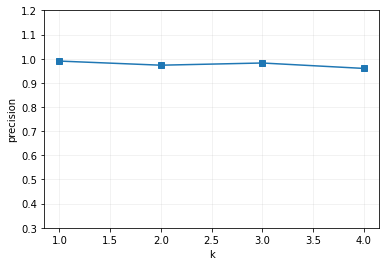

<Figure size 432x288 with 1 Axes>


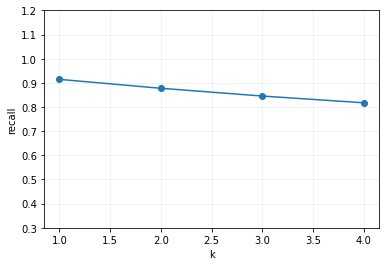

<Figure size 432x288 with 1 Axes>


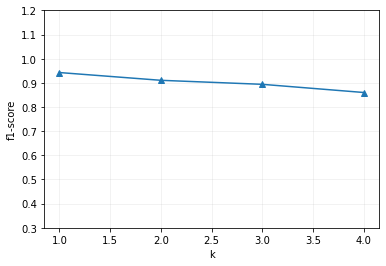

In [11]:
metrics = ['precision','recall','f1-score']
for indm,metric in enumerate(metrics):
    plt.figure()
    plt.plot(rangek,avgs[:,indm],marker=next(markers))
    #plt.fill_between(rangek,avgs[:,indm]+stds[:,indm],avgs[:,indm]-stds[:,indm],alpha=.2)
    plt.xlabel('k');plt.ylabel(metric)
    plt.grid(alpha=.2); plt.ylim(0.3,1.2)

#### sensitivity to sample size

In [12]:
indk = 0
_record = record[indk,:]

In [13]:
avgs = list(); stds = list()
for indsize in range(len(rangesize)):
    __record = remove_none(_record[indsize,:])
    avg,std = __record.mean(0), __record.std(0)
    avgs.append(avg); stds.append(std)
avgs = np.array(avgs); stds = np.array(stds)

3 rows with None.
4 rows with None.
3 rows with None.
1 rows with None.


<Figure size 432x288 with 1 Axes>


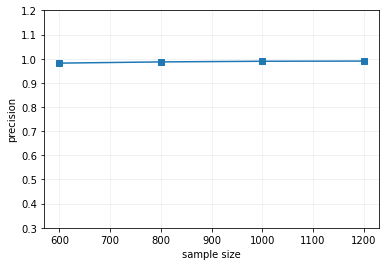

<Figure size 432x288 with 1 Axes>


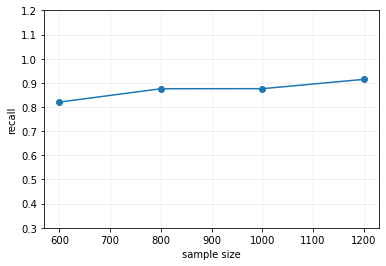

<Figure size 432x288 with 1 Axes>


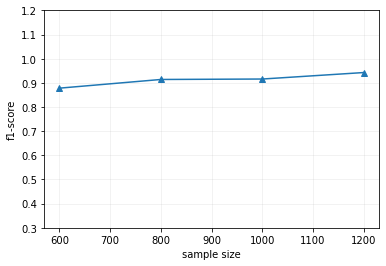

In [14]:
metrics = ['precision','recall','f1-score']
for indm,metric in enumerate(metrics):
    plt.figure()
    plt.plot(rangesize,avgs[:,indm],marker=next(markers))
    #plt.fill_between(rangek,avgs[:,indm]+stds[:,indm],avgs[:,indm]-stds[:,indm],alpha=.2)
    plt.xlabel('sample size');plt.ylabel(metric)
    plt.grid(alpha=.2); plt.ylim(0.3,1.2)